In [1]:
import numpy as np
import pandas as pd
#from google.colab import drive
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

import zipfile

In [2]:
from sklearn.decomposition import PCA

In [3]:
sns.set_theme()

In [4]:
RANDOM_SEED = 33
np.random.seed(RANDOM_SEED)

# Download CIC IDS 2017

[Este](https://www.unb.ca/cic/datasets/ids-2017.html) conjunto de dados contém informações sobre fluxos de rede, representando tanto o tráfego benigno quanto ataques populares. Para o ambiente de teste desta coleta de dados, uma rede foi configurada para o atacante e uma rede separada foi configurada para as vítimas, esta última contendo firewalls, roteadores, switches, servidores e estações de trabalho em execução em diferentes versões dos sistemas operacionais Windows e Linux. Para gerar o tráfego benigno, os autores utilizaram um sistema desenvolvido por eles mesmos, que então extraiu o comportamento abstrato de 25 usuários com base em diferentes protocolos de aplicação. Os dados foram coletados ao longo de cinco dias de atividade de rede e foram processados para extrair mais de 80 features do conjunto de dados usando a ferramenta CICFlowMeter8.


In [5]:
# Baixando dataset CIC IDS 2017 mais rápido através de código de arquivo do Google Drive
#!gdown '1WtbUHBpANHLMVVHuaFr9-pGUyeW6QhdD' -O CIC_IDS_2017.zip

In [6]:
#!tar -xf CIC_IDS_2017.zip

# Carregando os dados

In [ ]:
with zipfile.ZipFile("../../../Dados/CIC_IDS_2017.zip", 'r') as zip_ref:
    zip_ref.extractall("../../../Dados/")

In [6]:
df_list = []
for file in os.listdir('../../../Dados/MachineLearningCVE/'):
  df_aux = pd.read_csv(f'../../../Dados/MachineLearningCVE/{file}')
  df_list.append(df_aux)
df = pd.concat(df_list, ignore_index=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [ ]:
list(df.columns)[:6]

[' Destination Port',
 ' Flow Duration',
 ' Total Fwd Packets',
 ' Total Backward Packets',
 'Total Length of Fwd Packets',
 ' Total Length of Bwd Packets']

Algumas colunas tem seus nomes iniciados com espaços ou finalizados com espaços. Vamos remover esses espaços não úteis para ajustar o nome das colunas.

In [ ]:
def remove_initial_and_ending_spaces(name):
    regex = r'^(?:\s+)?(?P<gp>.+?)(?:\s+)?$'
    mo = re.search(regex, name)
    if mo is not None:
      return mo['gp']
    else:
      print(f'Deu erro em: {name}')
      return name

In [ ]:
for col in df.columns:
    df = df.rename({col:remove_initial_and_ending_spaces(col)}, axis='columns')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  

# Limpando os dados

É necessário limpar os dados realizando:
- Descarte de registros duplicados
- Descarte de registros com valores NaN (Not a Number)/ Null / NA (Not Available)
- Evitar registros com valores não finitos. Nesse caso, uma abordagem válida é substituirmos os mesmos pelo maior valor finito presente no dataset.

Registros duplicados

In [ ]:
df[df.duplicated()]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
2109,80,77,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2257,443,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2749,443,49,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2862,443,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2877,443,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830701,53,179,2,2,46,46,23,23,23.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830725,53,161,2,2,82,114,41,41,41.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830726,53,212,2,2,84,162,42,42,42.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830731,443,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
# Descartando duplicadas
initial_len = df.shape[0]
df = df.drop_duplicates()
print(f'Tamanho inicial: {initial_len}, tamanho final {df.shape[0]} | Descartadas {initial_len - df.shape[0]} duplicadas')

Tamanho inicial: 2830743, tamanho final 2522362 | Descartadas 308381 duplicadas


Registros com valores Null/NaN/NA

In [ ]:
df.columns[df.isna().any(axis=0)]

Index(['Flow Bytes/s'], dtype='object')

In [ ]:
df[df.isna().any(axis=1)][['Flow Bytes/s']]

,Flow Bytes/s
6796,NaN
14739,NaN
15047,NaN
209728,NaN
238569,NaN
...,...
2740049,NaN
2767532,NaN
2791593,NaN
2809052,NaN


In [ ]:
# Descartando registros com valores NaN/Null/NA
initial_len = df.shape[0]
df = df.dropna()
print(f'Tamanho inicial: {initial_len}, tamanho final {df.shape[0]} | Descartados {initial_len - df.shape[0]} registros com valores NA')

Tamanho inicial: 2522362, tamanho final 2522009 | Descartados 353 registros com valores NA


In [ ]:
df = df.reset_index(drop=True)

Registros com valores não finitos

In [ ]:
df_columns_isfinite = np.isfinite(df.drop(['Label'], axis='columns')).all(axis=0)
df_columns_isfinite[df_columns_isfinite == False]

Flow Bytes/s      False
Flow Packets/s    False
dtype: bool

In [ ]:
df_rows_isfinite = np.isfinite(df.drop(['Label'], axis='columns')).all(axis=1)
inf_indexes = df_rows_isfinite[df_rows_isfinite == False].index
df.iloc[inf_indexes][['Flow Bytes/s', 'Flow Packets/s', 'Flow Duration']]

,Flow Bytes/s,Flow Packets/s,Flow Duration
65,inf,inf,0
1767,inf,inf,0
1890,inf,inf,0
3365,inf,inf,0
8001,inf,inf,0
...,...,...,...
2515309,inf,inf,0
2515565,inf,inf,0
2516784,inf,inf,0
2516908,inf,inf,0


In [ ]:
# Evitando registros com valores não finitos
max_finite_flow_packets_per_sec = df[np.isfinite(df['Flow Packets/s'])]['Flow Packets/s'].max()
max_finite_flow_bytes_per_sec = df[np.isfinite(df['Flow Bytes/s'])]['Flow Bytes/s'].max()

df.loc[df['Flow Packets/s'] == np.inf, 'Flow Packets/s'] = max_finite_flow_packets_per_sec
df.loc[df['Flow Bytes/s'] == np.inf, 'Flow Bytes/s'] = max_finite_flow_bytes_per_sec

# Mini análise exploratória

### Quantidade de instâncias benignas x maliciosas

<Axes: xlabel='Label', ylabel='count'>

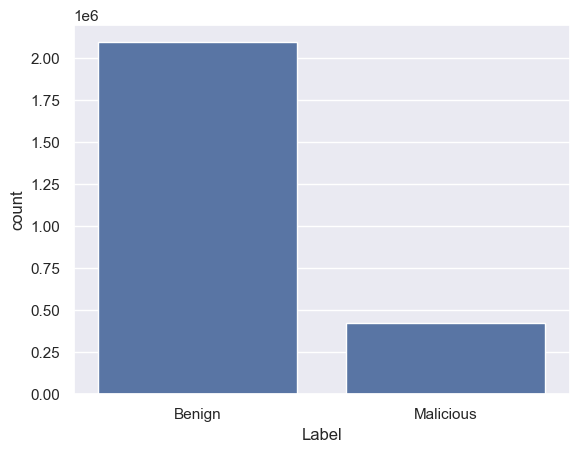

In [ ]:
sns.countplot(data=df['Label'].apply(lambda label: 'Malicious' if label != 'BENIGN' else 'Benign').to_frame(), x='Label')

**Dados não balanceados**. Impactos:
- Dificuldade de treinar modelos supervisionados
- Dificuldade de avaliar resultados com métricas tradicionais como acurácia

### Quantidade de instâncias por tipo de ataque

Abaixo está um descritivo para os ataques do dataset:

**DoS (Denial of Service)**: Esses ataques, como "DoS Hulk", "DoS GoldenEye", "DoS Slowloris", "DoS Slowhttptest" e "DDoS" visam tornar temporariamente uma máquina ou recurso de rede indisponível, sendo diferenciados pelo protocolo e estratégia usados para causar a negação de serviço. No caso do "DDoS", várias máquinas Windows 8.1 foram usadas para enviar solicitações UDP, TCP e HTTP.

**FTP Patator" e "SSH Patator**: Usam o software Patator para adivinhar senhas por força bruta com o uso de listas de palavras.

**Web - Brute Force**: Usa força bruta em uma aplicação com listas de palavras.

**Web - Injeção de SQL**: Esse ataque explora vulnerabilidades em máquinas conectadas publicamente à Internet usando injeção SQL.

**Web - XSS (Cross-Site Scripting)**: Representa injeções de scripts em aplicativos da web, visando a execução de ações maliciosas por outros usuários do aplicativo.

**PortScan**: Realizados com a ferramenta NMap, esses ataques buscam informações sobre os serviços e portas abertas em um alvo.

**Bot**: Esse ataque tem várias possibilidades, como roubo de dados, envio de spam e acesso ao dispositivo. .

**Infiltration**: Baseado na infecção de uma máquina após um usuário abrir um arquivo malicioso.

In [ ]:
df['Label'] = df['Label'].replace({'Web Attack � Brute Force':'Brute Force', 'Web Attack � XSS':'XSS', 'Web Attack � Sql Injection':'Sql Injection'})

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'DoS Hulk'),
  Text(1, 0, 'DDoS'),
  Text(2, 0, 'PortScan'),
  Text(3, 0, 'DoS GoldenEye'),
  Text(4, 0, 'FTP-Patator'),
  Text(5, 0, 'DoS slowloris'),
  Text(6, 0, 'DoS Slowhttptest'),
  Text(7, 0, 'SSH-Patator'),
  Text(8, 0, 'Bot'),
  Text(9, 0, 'Brute Force'),
  Text(10, 0, 'XSS'),
  Text(11, 0, 'Infiltration'),
  Text(12, 0, 'Sql Injection'),
  Text(13, 0, 'Heartbleed')])

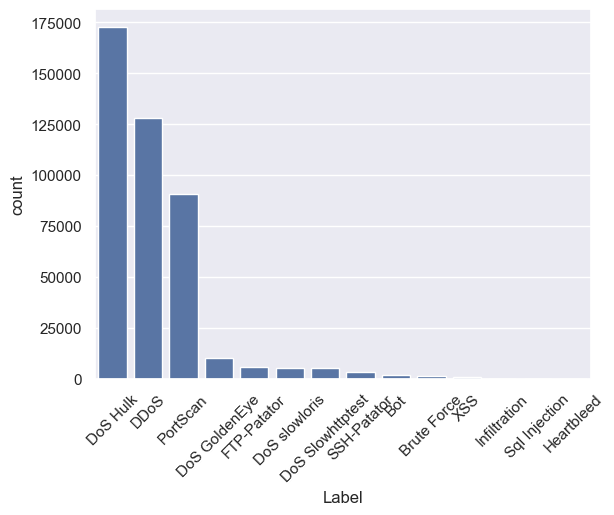

In [ ]:
sns.countplot(data=df.query('Label != "BENIGN"')[['Label']], x='Label', order = df.query('Label != "BENIGN"')['Label'].value_counts().index)
plt.xticks(rotation=45)

Ataques menos representados

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Infiltration'),
  Text(1, 0, 'Brute Force'),
  Text(2, 0, 'XSS'),
  Text(3, 0, 'Sql Injection'),
  Text(4, 0, 'Heartbleed')])

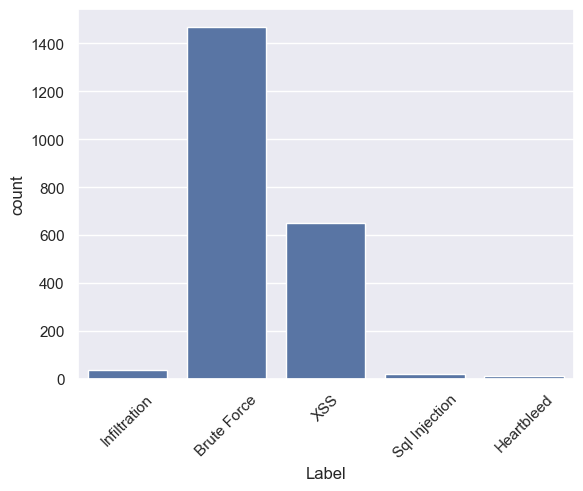

In [ ]:
N_LESS_REPRESENTED_LABELS = 5

sns.countplot(data=df[df['Label'].isin(df.groupby('Label').size().sort_values(ascending=False)[(-1)*N_LESS_REPRESENTED_LABELS:].index)], x='Label')
plt.xticks(rotation=45)

### Estatísticas dos dados

In [ ]:
interesting_cols = ['Flow Duration', 'Flow Bytes/s', 'Total Fwd Packets', 'Average Packet Size', 'SYN Flag Count']
df[interesting_cols].describe()

,Flow Duration,Flow Bytes/s,Total Fwd Packets,Average Packet Size,SYN Flag Count
count,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06
mean,1.658364e+07,2.404467e+06,1.027750e+01,2.123412e+02,4.874487e-02
std,3.522618e+07,5.254864e+07,7.942294e+02,3.454504e+02,2.153342e-01
min,-1.300000e+01,-2.610000e+08,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.080000e+02,1.194510e+02,2.000000e+00,9.000000e+00,0.000000e+00
50%,5.058700e+04,3.722028e+03,2.000000e+00,8.075000e+01,0.000000e+00
75%,5.330376e+06,1.079162e+05,6.000000e+00,1.796923e+02,0.000000e+00
max,1.200000e+08,2.071000e+09,2.197590e+05,3.893333e+03,1.000000e+00


In [ ]:
true_labels = df['Label']
print(true_labels.value_counts())
print(len(df))

Label
BENIGN              2096134
DoS Hulk             172846
DDoS                 128016
PortScan              90819
DoS GoldenEye         10286
FTP-Patator            5933
DoS slowloris          5385
DoS Slowhttptest       5228
SSH-Patator            3219
Bot                    1953
Brute Force            1470
XSS                     652
Infiltration             36
Sql Injection            21
Heartbleed               11
Name: count, dtype: int64
2522009


# Dividindo dados nos conjuntos de treino, validação e teste

**Conjunto de treino**

Para a detecção de anomalias, vamos usar somente os dados que representam o tráfego benigno para o conjunto de treino. Dessa forma, os algoritmos de clustering vão ser capazes de identificar padrões e desvios em relação ao comportamento normal (benigno) dos dados.

**Conjuntos de validação e teste**

Porém, devem ser incluídos dados que representam o tráfego maliciosos nos conjuntos de validação e teste. Esses dados maliciosos no conjunto de validação são importantes para que possamos definir um *threshold* para que seja possível detectar anomalias. Além disso, os dados maliciosos também precisam ser incluídos no conjunto de teste para que possamos avaliar o desempenho do nosso modelo.

In [ ]:
df_train = df.query('Label == "BENIGN"').sample(frac=0.6, random_state=RANDOM_SEED)
df_val_test = df.drop(df_train.index)

df_train = df_train.reset_index(drop=True)
df_val_test = df_val_test.reset_index(drop=True)

#class_train = df_train['Label']
X_train = df_train.drop('Label', axis='columns')

In [ ]:
X_val, X_test, classes_val, classes_test = train_test_split(df_val_test.drop('Label', axis='columns'), df_val_test['Label'], test_size=0.65, stratify=df_val_test['Label'], random_state=RANDOM_SEED)

X_val, X_test = X_val.reset_index(drop=True), X_test.reset_index(drop=True)
classes_val, classes_test =  classes_val.reset_index(drop=True), classes_test.reset_index(drop=True)

y_val, y_test = classes_val.apply(lambda c: 0 if c == 'BENIGN' else 1), classes_test.apply(lambda c: 0 if c == 'BENIGN' else 1)

In [ ]:
del df_train, df_val_test

# Analisando correlação entre features

**Por que remover features?**

Vamos descartar features com alta correlação evitando passar informações redundantes ao modelo. Dessa forma, conseguiremos obter um modelo mais simples e com menor custo computacional.

In [ ]:
def get_highly_correlated_features(correlation_matrix, threshold):
  correlated_pairs = []
  for i in range(len(correlation_matrix.columns)):
    for j in range(i):
      if abs(correlation_matrix.iloc[i, j]) > threshold:
        pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
        coefficient = correlation_matrix.iloc[i, j]
        correlated_pairs.append((pair, coefficient))
  return sorted(correlated_pairs, key= lambda pair: pair[1], reverse=True)


In [ ]:
corr_matrix = X_train.corr().abs()
correlation_list = get_highly_correlated_features(corr_matrix, 0.95)

In [ ]:
print(X_train.shape[1])

78


In [ ]:
correlation_list[:10]

[(('Avg Bwd Segment Size', 'Bwd Packet Length Mean'), 1.0000000000000002),
 (('SYN Flag Count', 'Fwd PSH Flags'), 1.0),
 (('CWE Flag Count', 'Fwd URG Flags'), 1.0),
 (('Avg Fwd Segment Size', 'Fwd Packet Length Mean'), 1.0),
 (('Fwd Header Length.1', 'Fwd Header Length'), 1.0),
 (('Subflow Fwd Packets', 'Total Fwd Packets'), 1.0),
 (('Subflow Fwd Bytes', 'Total Length of Fwd Packets'), 1.0),
 (('Subflow Bwd Packets', 'Total Backward Packets'), 1.0),
 (('Subflow Bwd Bytes', 'Total Length of Bwd Packets'), 0.9999998619402976),
 (('Subflow Fwd Packets', 'Total Backward Packets'), 0.9991954734499192)]

In [ ]:
# Drop high correlated features in correlation list

f2drop = []
for feature_pair, _ in correlation_list:
  if feature_pair[0] not in f2drop and feature_pair[1] not in f2drop:
    f2drop.append(feature_pair[1])

In [ ]:
f2drop

['Bwd Packet Length Mean',
 'Fwd PSH Flags',
 'Fwd URG Flags',
 'Fwd Packet Length Mean',
 'Fwd Header Length',
 'Total Fwd Packets',
 'Total Length of Fwd Packets',
 'Total Backward Packets',
 'Total Length of Bwd Packets',
 'Subflow Fwd Packets',
 'Flow Duration',
 'RST Flag Count',
 'Subflow Bwd Packets',
 'Packet Length Mean',
 'Flow IAT Max',
 'Idle Mean',
 'Fwd IAT Total',
 'Fwd Packet Length Max',
 'Max Packet Length',
 'Bwd IAT Max',
 'Bwd IAT Mean',
 'Fwd IAT Max',
 'Fwd IAT Mean',
 'Idle Max']

A feature "Destination Port", também não fornece muita contribuição devido que a mesma está codificada com valores inteiros, indicando uma relação de grandeza, como 44720 > 80, que não apresenta sentido semântico quando se trata da porta de destino de um fluxo de rede.

In [ ]:
f2drop = f2drop + ['Destination Port']

In [ ]:
X_train = X_train.drop(f2drop, axis='columns')
X_val = X_val.drop(f2drop, axis='columns')
X_test = X_test.drop(f2drop, axis='columns')

In [ ]:
print(X_train.shape[1])

53


# Normalizando os Dados

Eu testei com a normalização dos dados, mas não obtive um resultado muito diferente, e vi que a normalização dos dados não é necessária nos modelos: Isolation Forest e OCSVM. Então decidi por não normalizar na maiorias dos testes, incluindo o teste final.

In [ ]:
#std_scaler = StandardScaler()
#std_scaler = std_scaler.fit(X_train)

#norm_X_train = std_scaler.transform(X_train)
#norm_X_val = std_scaler.transform(X_val)
#norm_X_test = std_scaler.transform(X_test)

In [ ]:
#del X_train, X_val, X_test

# Funções de Avaliação

In [ ]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

In [ ]:
def get_tpr_per_attack(y_labels, y_pred):
  aux_df = pd.DataFrame({'Label':y_labels,'prediction':y_pred})
  total_per_label = aux_df['Label'].value_counts().to_dict()
  correct_predictions_per_label = aux_df.query('Label != "BENIGN" and prediction == True').groupby('Label').size().to_dict()
  tpr_per_attack = {}
  for attack_label, total in total_per_label.items():
    if attack_label == 'BENIGN':
      continue
    tp = correct_predictions_per_label[attack_label] if attack_label in correct_predictions_per_label else 0
    tpr = tp/total
    tpr_per_attack[attack_label] = tpr
  return tpr_per_attack

In [ ]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

# Detecção de Anomalias com o Isolation Forest

#### Escolha dos parâmetros

**contamination**: A proporção de pacotes maliciosos é de 0.1688633942226217, como o parâmetro **contamination** é a taxa esperada de anomalias, então eu defini este valor para este parâmetro.

**max_fetures**: Este parâmetro limita o número máximo de features que o isolation forest irá usar, segundo a documentação do isolation forest, o valor padrão deste parâmetro é 1.0, então, achei necessário colocar este parâmetro com um valor igual ao número máximo de features usados, que neste caso é 53.

#### Treinamento

In [ ]:
from sklearn.ensemble import IsolationForest

N_ESTIMATORS = 100

model_iforest = IsolationForest(n_estimators = N_ESTIMATORS, contamination = 0.1688633942226217, bootstrap= False, max_features= 53, n_jobs=-1, random_state=RANDOM_SEED).fit(X_train)

## Conjunto de validação

In [ ]:
val_scores_iforest = model_iforest.score_samples(X_val)

In [ ]:
val_scores_iforest = np.abs(val_scores_iforest)

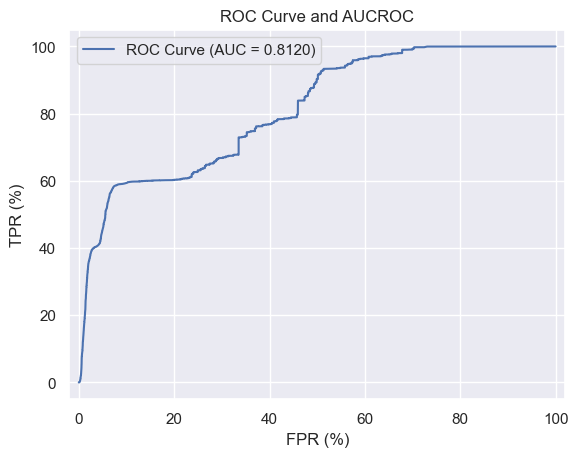

In [ ]:
plot_roc_curve(y_val, val_scores_iforest)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, val_scores_iforest)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr')

,fpr,tpr,thresholds,youden-index
23189,0.074944,0.584948,0.469690,0.510004
23193,0.074964,0.584961,0.469667,0.509997
23191,0.074961,0.584955,0.469672,0.509994
23187,0.074913,0.584901,0.469727,0.509988
23195,0.074985,0.584968,0.469658,0.509983
...,...,...,...,...
55,0.000947,0.000067,0.670817,-0.000880
56,0.000954,0.000067,0.670334,-0.000887
58,0.000964,0.000074,0.670055,-0.000891
60,0.000975,0.000081,0.669947,-0.000894


In [ ]:
BEST_IFOREST_VALIDATION_THRESHOLD = 0.451924

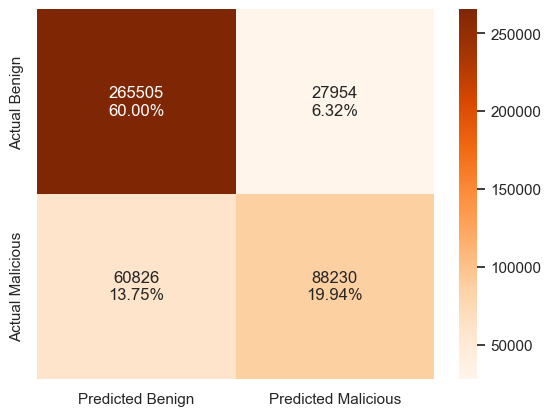

In [ ]:
plot_confusion_matrix(y_val, val_scores_iforest > BEST_IFOREST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_val, val_scores_iforest > BEST_IFOREST_VALIDATION_THRESHOLD)

{'acc': 0.7993740325186717,
 'tpr': 0.5919251824817519,
 'fpr': 0.09525691834293717,
 'precision': 0.7593988845279901,
 'f1-score': 0.6652842708490424}

In [ ]:
get_tpr_per_attack(classes_val, val_scores_iforest > BEST_IFOREST_VALIDATION_THRESHOLD)

{'DoS Hulk': 0.8984560962708278,
 'DDoS': 0.6320135696112128,
 'PortScan': 0.007613175197407745,
 'DoS GoldenEye': 0.7238888888888889,
 'FTP-Patator': 0.0004816955684007707,
 'DoS slowloris': 0.5883289124668435,
 'DoS Slowhttptest': 0.8431693989071039,
 'SSH-Patator': 0.0,
 'Bot': 0.02342606149341142,
 'Brute Force': 0.04474708171206226,
 'XSS': 0.02631578947368421,
 'Infiltration': 0.6923076923076923,
 'Sql Injection': 0.0,
 'Heartbleed': 1.0}

### Usando a predição direta do modelo

In [ ]:
val_preds_iforest = model_iforest.predict(X_val)

In [ ]:
val_preds_iforest[val_preds_iforest == 1] = 0
val_preds_iforest[val_preds_iforest == -1] = 1

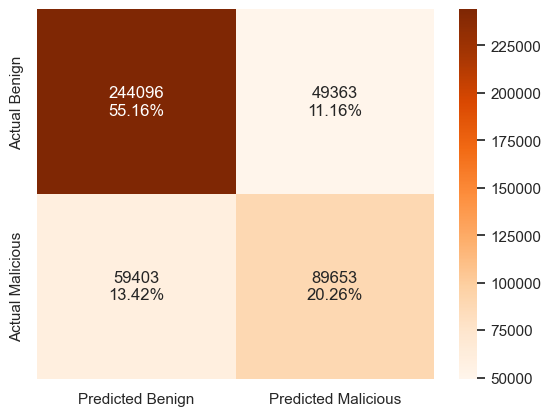

In [ ]:
plot_confusion_matrix(y_val, val_preds_iforest)

In [ ]:
get_overall_metrics(y_val, val_preds_iforest)

{'acc': 0.7542094618261528,
 'tpr': 0.601471930012881,
 'fpr': 0.16821089147035873,
 'precision': 0.6449113771076711,
 'f1-score': 0.6224346691105002}

In [ ]:
get_tpr_per_attack(classes_val, val_preds_iforest)

{'DoS Hulk': 0.899233007140968,
 'DDoS': 0.6357853858858189,
 'PortScan': 0.017806021329474314,
 'DoS GoldenEye': 0.9152777777777777,
 'FTP-Patator': 0.0009633911368015414,
 'DoS slowloris': 0.6244031830238727,
 'DoS Slowhttptest': 0.9043715846994536,
 'SSH-Patator': 0.0044365572315882874,
 'Bot': 0.03074670571010249,
 'Brute Force': 0.04669260700389105,
 'XSS': 0.02631578947368421,
 'Infiltration': 0.7692307692307693,
 'Sql Injection': 0.14285714285714285,
 'Heartbleed': 1.0}

## Conjunto de teste

In [ ]:
test_scores_iforest = model_iforest.score_samples(X_test)

In [ ]:
test_scores_iforest = np.abs(test_scores_iforest)

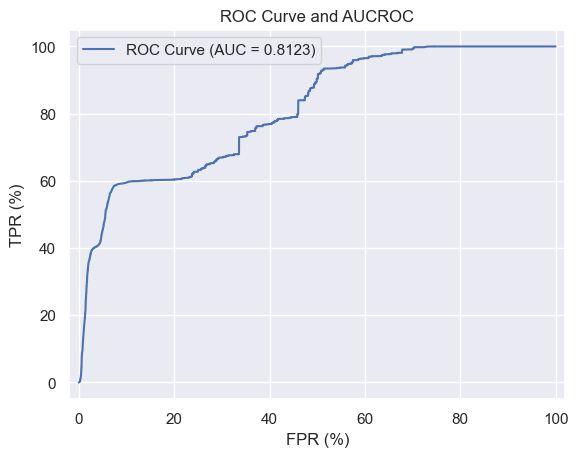

In [ ]:
plot_roc_curve(y_test, test_scores_iforest)

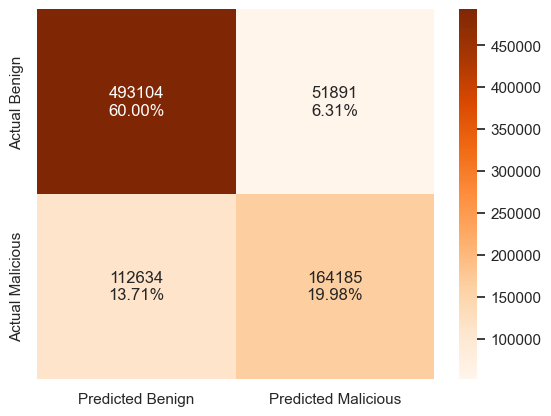

In [ ]:
plot_confusion_matrix(y_test, test_scores_iforest > BEST_IFOREST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_test, test_scores_iforest > BEST_IFOREST_VALIDATION_THRESHOLD)

{'acc': 0.7998026317390553,
 'tpr': 0.5931131894848258,
 'fpr': 0.0952137175570418,
 'precision': 0.7598483866787612,
 'f1-score': 0.6662067986082228}

In [ ]:
get_tpr_per_attack(classes_test, test_scores_iforest > BEST_IFOREST_VALIDATION_THRESHOLD)

{'DoS Hulk': 0.9009968847352025,
 'DDoS': 0.6323999519288547,
 'PortScan': 0.007284184848895515,
 'DoS GoldenEye': 0.7322763984445109,
 'FTP-Patator': 0.00077780658542909,
 'DoS slowloris': 0.5817142857142857,
 'DoS Slowhttptest': 0.8384343731606827,
 'SSH-Patator': 0.0,
 'Bot': 0.024409448818897637,
 'Brute Force': 0.053347280334728034,
 'XSS': 0.030660377358490566,
 'Infiltration': 0.8695652173913043,
 'Sql Injection': 0.0,
 'Heartbleed': 1.0}

# Detecção de Anomalias com o OCSVM

In [ ]:
from sklearn.svm import OneClassSVM

#### Escolha de parâmetros

**kernel**: Eu testei todos os kernels, e apenas o **rbf** gerou um resultado satisfatório, todos os outros foram muito ruins. Eu pesquisei a teoria por trás dos Kernels, mas não consegui entender porque apenas o **rbf** foi eficaz.

**nu**: A proporção de pacotes maliciosos é de 0.1688633942226217, como o parâmetro **nu** é a taxa esperada de anomalias, então eu defini este valor para este parâmetro. E nos testes, este valor se mostrou muito melhor que outros valores maiores ou menores.

**gamma**: Testei todas as opções de **gamma**, incluindo números, e apenas a opção **scale** se mostrou eficaz, todas as outras geraram resultados muito ruins.

**cache_size**: É a quantidade de memória usada para o cache do modelo, coloquei um número muito grande pra poder usar o máximo possível.

#### Treinamento

Usei apenas 15% dos dados de treino, por limitações de poder computacional.

In [ ]:
random_indexes_t = np.random.choice(X_train.shape[0], int(X_train.shape[0]*0.15), replace=False)

X_train_subset = X_train.iloc[random_indexes_t]

In [ ]:
model_ocsvm = OneClassSVM(nu=0.1688633942226217, kernel="rbf", gamma='scale', cache_size=10000000000000)
model_ocsvm.fit(X_train_subset)

OneClassSVM(cache_size=10000000000000, nu=0.1688633942226217)

Percebi que o isolation forest treina bem mais rápido, até pude usar os dados de treinamento completamente, diferente do OCSVM. Além disso, achei que os parâmetros **nu** e **contamination** são semelhantes, pois ambos se referem à taxa de anomalias esperadas.

## Validação

### Score Samples

In [ ]:
val_scores_ocsvm = model_ocsvm.score_samples(X_val)

In [ ]:
val_scores_ocsvm = np.abs(val_scores_ocsvm)

In [ ]:
#Normalizando para uma escala de 0 a 1
min = 0
max = 1

normalized_val_scores = (val_scores_ocsvm - np.min(val_scores_ocsvm)) / (np.max(val_scores_ocsvm) - np.min(val_scores_ocsvm)) * (max - min) + min

del val_scores_ocsvm

Eu não sei como definir um bom treshold, então testei vários valores, e nenhum me satisfez, eu até tentei normalizar de 0 a 1, mas ainda sim não consegui identificar uma pontuação dos dados que fosse definido como ameaça, também tentei mudar o treshold pra aproximar a matriz de confusão com a matriz de confusão das predições do modelo, mas sem sucesso, pois as proporções de pontuação eram diferentes das proporções de decisão das predições do modelo.

In [ ]:
BEST_OCSVM_VALIDATION_THRESHOLD = 0.935

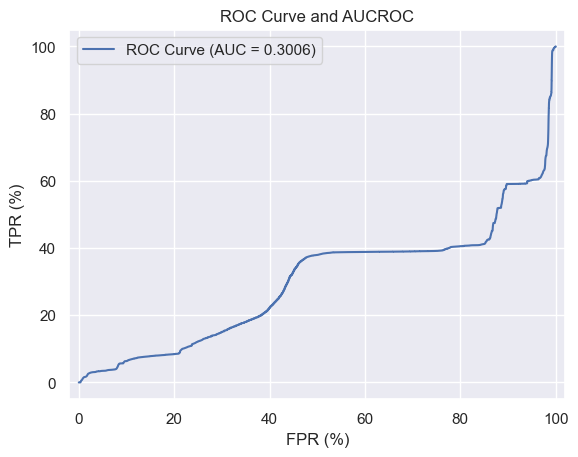

In [ ]:
plot_roc_curve(y_val, normalized_val_scores)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, normalized_val_scores)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr')

,fpr,tpr,thresholds,youden-index
3867,0.019682,0.025963,0.983608,0.006281
3875,0.019730,0.026010,0.983592,0.006280
3865,0.019679,0.025957,0.983611,0.006278
3871,0.019706,0.025984,0.983599,0.006277
3873,0.019720,0.025997,0.983594,0.006277
...,...,...,...,...
48387,0.851216,0.412758,0.955557,-0.438458
48380,0.851179,0.412717,0.955557,-0.438461
48383,0.851199,0.412737,0.955557,-0.438461
48385,0.851206,0.412744,0.955557,-0.438462


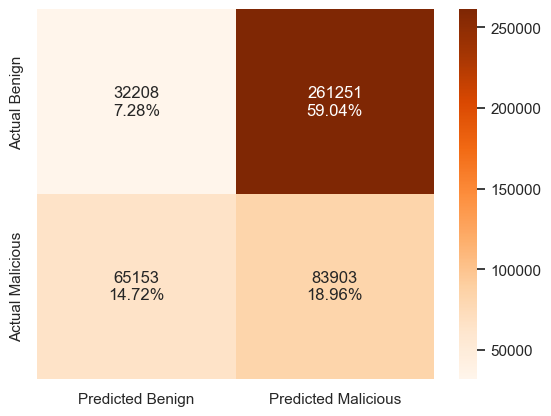

In [ ]:
plot_confusion_matrix(y_val, normalized_val_scores > BEST_OCSVM_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_val, normalized_val_scores > BEST_OCSVM_VALIDATION_THRESHOLD)

{'acc': 0.2623888455758562,
 'tpr': 0.5628958243881494,
 'fpr': 0.8902470191747399,
 'precision': 0.2430885923384924,
 'f1-score': 0.3395439185771231}

### OCSVM Predictions

In [ ]:
ocsvm_predicoes = model_ocsvm.predict(X_val)

In [ ]:
ocsvm_predicoes[ocsvm_predicoes == 1] = 0
ocsvm_predicoes[ocsvm_predicoes == -1] = 1

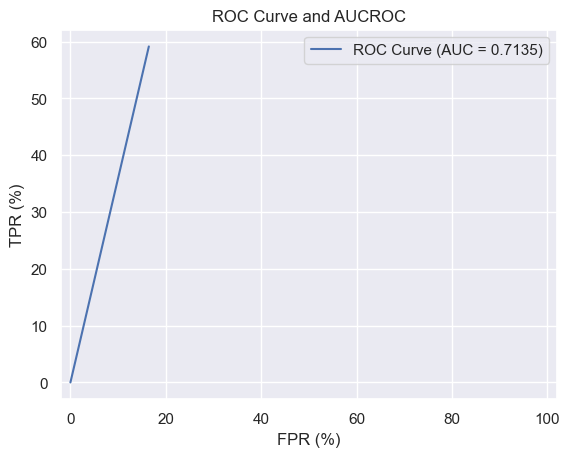

In [ ]:
plot_roc_curve(y_val, ocsvm_predicoes)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, ocsvm_predicoes)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr')

,fpr,tpr,thresholds,youden-index
1,0.164459,0.591442,1.0,0.426983
0,0.000000,0.000000,inf,0.000000
2,1.000000,1.000000,0.0,0.000000


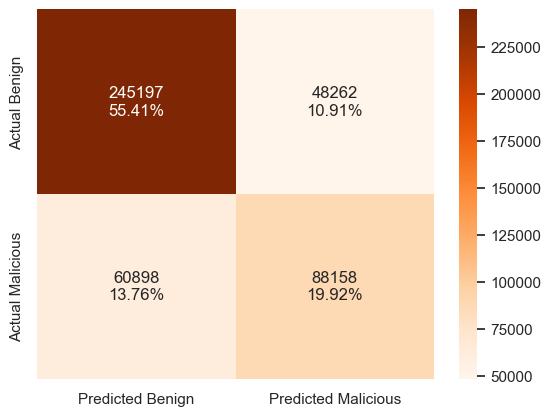

In [ ]:
plot_confusion_matrix(y_val, ocsvm_predicoes)

Consegui chegar numa proporção de TP e TN maiores que FP e FN. Durante a validação, tentei melhorar isto, mas sempre que eu conseguia detectar mais anomalias, uma parte dos dados benignos era considerado anomalias junto com os maliciosos, não consegui melhorar a detecção de anomalias sem sacrificar alguns dados benignos, isso ocorreu de forma semelhante nas partes de treshold.

In [ ]:
get_overall_metrics(y_val, ocsvm_predicoes)

{'acc': 0.7533190965278013,
 'tpr': 0.5914421425504508,
 'fpr': 0.16445908968544157,
 'precision': 0.6462248937105997,
 'f1-score': 0.617621095994059}

## Teste

### Score Samples

In [ ]:
test_scores_ocsvm = model_ocsvm.score_samples(X_test)

In [ ]:
test_scores_ocsvm = np.abs(test_scores_ocsvm)

In [ ]:
#Normalizando para uma escala de 0 a 1
min = 0
max = 1

normalized_test_scores = (test_scores_ocsvm - np.min(test_scores_ocsvm)) / (np.max(test_scores_ocsvm) - np.min(test_scores_ocsvm)) * (max - min) + min

del test_scores_ocsvm

In [ ]:
BEST_OCSVM_VALIDATION_THRESHOLD = 0.935

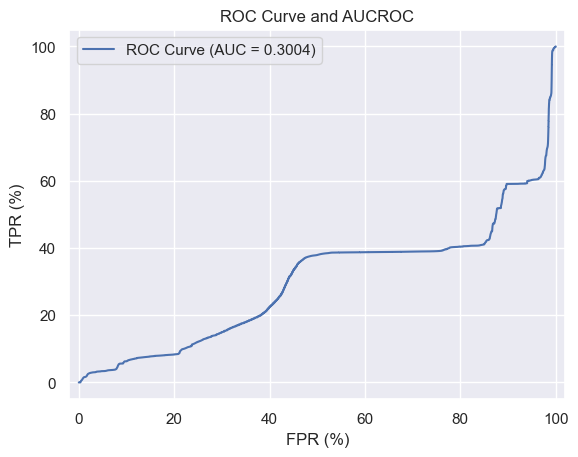

In [ ]:
plot_roc_curve(y_test, normalized_test_scores)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, normalized_test_scores)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr')

,fpr,tpr,thresholds,youden-index
6881,0.019411,0.025526,0.983875,0.006115
6883,0.019420,0.025533,0.983871,0.006113
6867,0.019371,0.025482,0.983893,0.006112
6871,0.019382,0.025493,0.983888,0.006111
6875,0.019389,0.025500,0.983884,0.006111
...,...,...,...,...
89007,0.849914,0.410954,0.955832,-0.438960
89008,0.849918,0.410954,0.955832,-0.438963
89014,0.849936,0.410969,0.955832,-0.438967
89010,0.849927,0.410958,0.955832,-0.438969


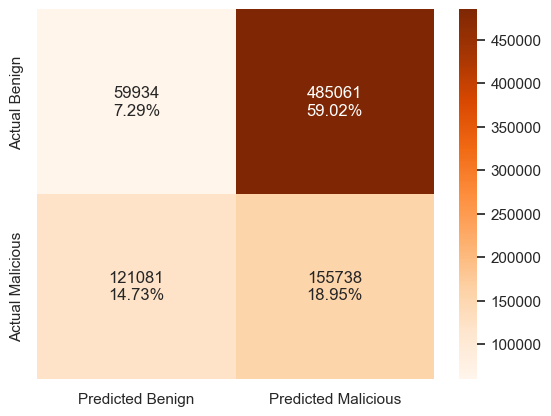

In [ ]:
plot_confusion_matrix(y_test, normalized_test_scores > BEST_OCSVM_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_test, normalized_test_scores > BEST_OCSVM_VALIDATION_THRESHOLD)

{'acc': 0.2624340787574804,
 'tpr': 0.5625986655540263,
 'fpr': 0.8900283488839347,
 'precision': 0.2430372082353437,
 'f1-score': 0.33943972328354505}

### OCSVM Predictions

In [ ]:
ocsvm_predicoes = model_ocsvm.predict(X_test)

In [ ]:
ocsvm_predicoes[ocsvm_predicoes == 1] = 0
ocsvm_predicoes[ocsvm_predicoes == -1] = 1

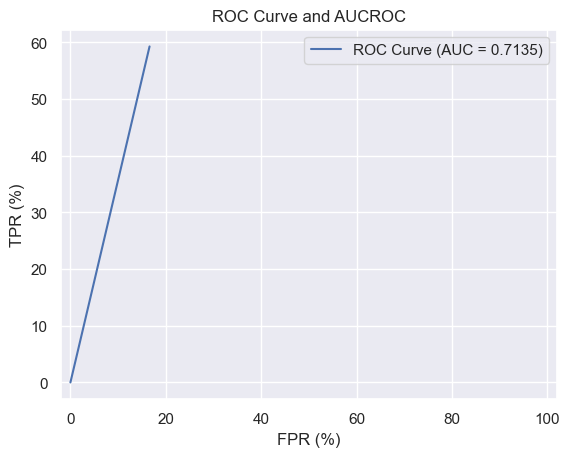

In [ ]:
plot_roc_curve(y_test, ocsvm_predicoes)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, ocsvm_predicoes)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr')

,fpr,tpr,thresholds,youden-index
1,0.165957,0.59286,1.0,0.426903
0,0.000000,0.00000,inf,0.000000
2,1.000000,1.00000,0.0,0.000000


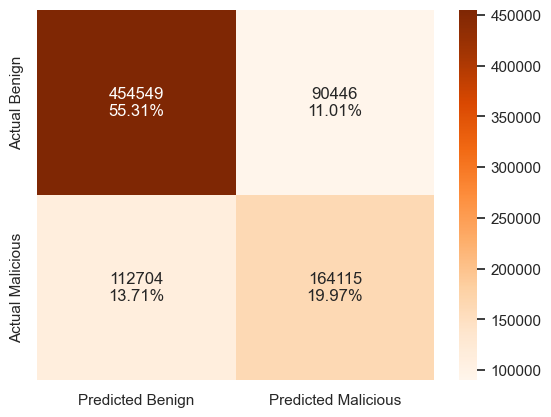

In [ ]:
plot_confusion_matrix(y_test, ocsvm_predicoes)

Os resultados da matriz de confusão do Isolation Forest foi muito parecido com este do OCSVM, são quase a mesma coisa. Lembrando que o treinamento do Isolation Forest foi usando 100% dos dados, enquanto do OCSVM foi com apenas 15%.

In [ ]:
get_overall_metrics(y_test, ocsvm_predicoes)

{'acc': 0.7528029456787059,
 'tpr': 0.5928603166690147,
 'fpr': 0.165957485848494,
 'precision': 0.6446981273643645,
 'f1-score': 0.6176935526365311}

In [ ]:
get_tpr_per_attack(classes_test, ocsvm_predicoes)

{'DoS Hulk': 0.9228215398308857,
 'DDoS': 0.6315707246725153,
 'PortScan': 0.00994375931698062,
 'DoS GoldenEye': 0.2950942267424469,
 'FTP-Patator': 0.0010370754472387865,
 'DoS slowloris': 0.61,
 'DoS Slowhttptest': 0.8905238375515009,
 'SSH-Patator': 0.030592734225621414,
 'Bot': 0.026771653543307086,
 'Brute Force': 0.010460251046025104,
 'XSS': 0.04716981132075472,
 'Infiltration': 0.9130434782608695,
 'Sql Injection': 0.14285714285714285,
 'Heartbleed': 1.0}

Percebi que a proporção de detecção de cada tipo de ataque se mantém muito próxima do resultado do Isolation Forest, com algumas exceções. Porém, existe uma diferença curiosa, no Isolation Forest, alguns ataques eram indetectáveis, já no OCSVM, NENHUM ataque ficou sem ser detectado, mesmo que tenha sido pouco detectado. Vale ressaltar que o treinamento do OCSVM foi com apenas 15% dos dados de treino, enquanto no Isolation Forest foram TODOS os dados de treino.